In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import odeint
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [234]:
def DE(X, t, params):
    """
    Returns a differential equation system encoding gene expression of a target gene,
    expression of a positive selection gene, expression of a negative selection gene,
    and cell growth. Expression and growth
        dg/dt = a - (y + beta(g)) * g
        dp/dt = a - (yp + beta(g)) * p
        dn/dt = an_gi(g) - (yn + beta(g)) * n
        dc/dt = beta(g) - c
    The `params` values must be provided as params = [a, y, B, K, N, ap, yp, Kp, Np, an, yn, Kn, Nn, Kgn, Ngn]
    
    Params:
    X:    np.array. array of DE variables, [cells, target gene, positive, negative]
    t:    np.float. time
    which:    str. One of None, `positive`, `negative` or `both`
    params:   parameters for DEs. depends on `which`.
    
    Output:
    dX/dt
    """
    c, g, p, n = X
    a, y, B, K, N, ap, yp, Kp, Np, an, yn, Kn, Nn, Kgn, Ngn = params

    def beta(gi, pi):
        """Cell division rate"""
        if ap == 0:
            return B / (K ** N + gi ** N)
        else:
            return B / (K ** N + gi ** N) * pi ** Np / (Kp + pi ** Np)

    def death(n):
        """Cell death rate"""
        # set death rate to equal 1 at the midpoint of the sigmoid curve
        if (n == 0) or (an == 0):
            return 1
        else:
            return 2 * n ** Nn / (Kn ** Nn + n ** Nn)

    def an_gi(gi):
        """Negative regulator intrinsic expression rate"""
        return an / (Kgn ** Ngn + gi ** Ngn)

    # differential equations:
    dgdt = a - (y + beta(g, p)) * g
    dpdt = ap - (yp + beta(g, p)) * g
    dndt = an_gi(g) - (yn + beta(g, p)) * n
    dcdt = beta(g, p) - death(n) * c
    return [dcdt, dgdt, dpdt, dndt]

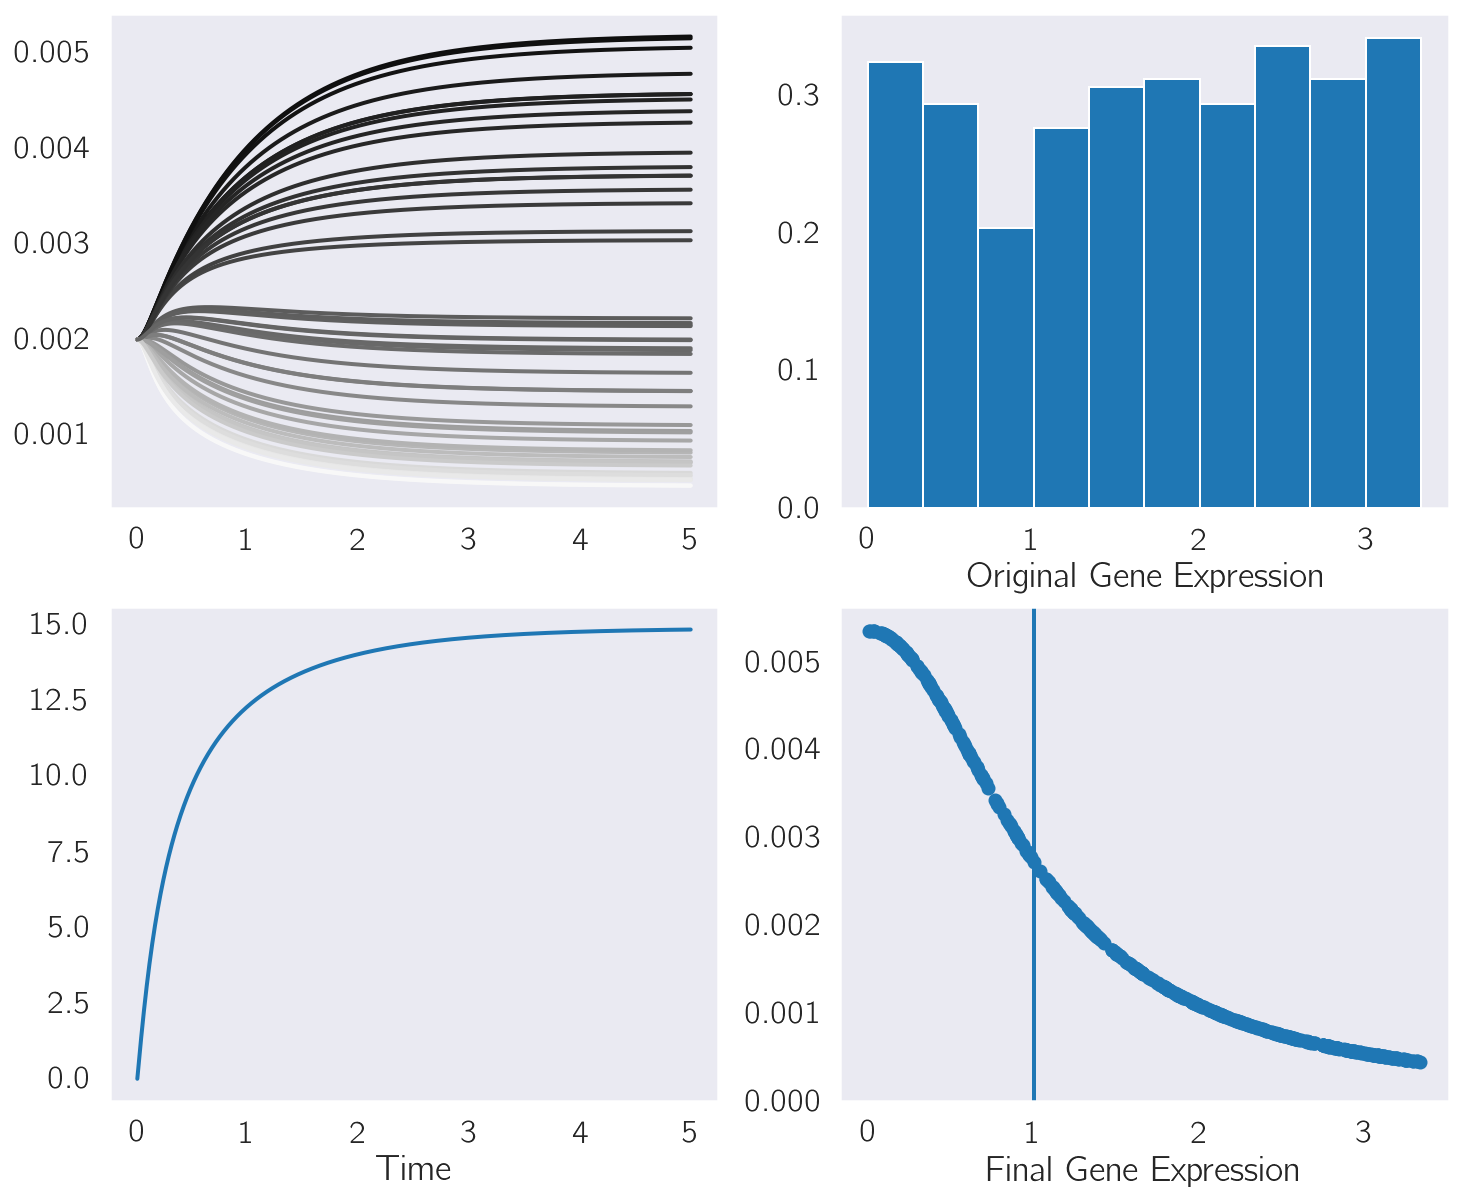

In [290]:
t = np.linspace(0, 5, 10000)
Ncells = 500
ad = np.random.uniform(0, 10, Ncells)

def simulation(params, Ncells=500, t=np.linspace(0, 5, 1000), adlim=[0, 10]):
    """
    Integrate DE for `Ncells` over time `t`, using random uniformly distributed target gene expression rates between the range specified by `adlim`
    
    Params:
    params:    array-like. 14 parameters (all params required for DE function minus gene expression rate, `a`)
    Ncells:    int. number of cells to simulate
    t:    np.array. time to carry out simulation
    adlim:    array-like, limits between which to uniformly sample expression rates
    
    Output:
    ad:    np.array. Array of sampled expression parameters
    sims:    np.array. Array of (sims, time).
    """
    ad = np.random.uniform(adlim[0], adlim[1], Ncells)
    X0 = [10 ** - 6, 0, 0, 0]
    # perform integration:
    sims = np.empty((len(ad), len(t)))
    p = params.copy()
    for i, ai in enumerate(ad):
        if type(params[4]) is str:
            multiplier = int(params[4])
            ap = multiplier * ai
            p[4] = ap
        
        c = odeint(DE, X0, t, args=([ai, *p],))
        sims[i, :] = c[:, 0]
    return ad, sims

def plot_sims(ad, sims, t, tp=-1):
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
    c = [str(ci) for ci in (ad - ad.min()) / ad.max()]

    # plot cell abundances
    for i in range(50):
#         ax[0, 0].plot(t, sims[i, :], color=c[i])
        ax[0, 0].plot(t, sims[i, :] / sims.sum(axis=0), color=c[i])
    
    # plot total cell population:
    ax[1, 0].plot(t, sims.sum(axis=0))
    ax[1, 0].set_xlabel('Time')
    
    # plot initial target gene expression rate distirbution:
    ax[0, 1].hist(ad / y, density=True)
    
    # plot final target gene expression rate distirbution, weighted by cell abundances:
    ax[1, 1].scatter(ad / y, sims[:, tp] / sims[:, tp].sum())
    ax[1, 1].axvline((ad / y * (sims[:, tp] / sims[:, tp].sum())).sum() / (sims[:, tp] / sims[:, tp].sum()).sum())
    
    # prettify
    ax[0, 1].set_xlabel('Original Gene Expression')
    ax[1, 1].set_xlabel('Final Gene Expression')
    ax[1, 1].set_ylim(0, (sims[:, tp] / sims[:, tp].sum().max()).max() * 1.05)

t = np.linspace(0, 5, 1000)
# params=y, B, K, N,
#        ap, yp, Kp, Np,
#        an, yn, Kn, Nn,
#        Kgn, Ngn
params = [3, 40 / len(ad), 1, 2,
          0, 1, 1, 1,
          0, 1, 1, 1,
          1, 1]
ad, sims = simulation(params, Ncells=500, t=t, adlim=[0, 10])
plot_sims(ad, sims, t)

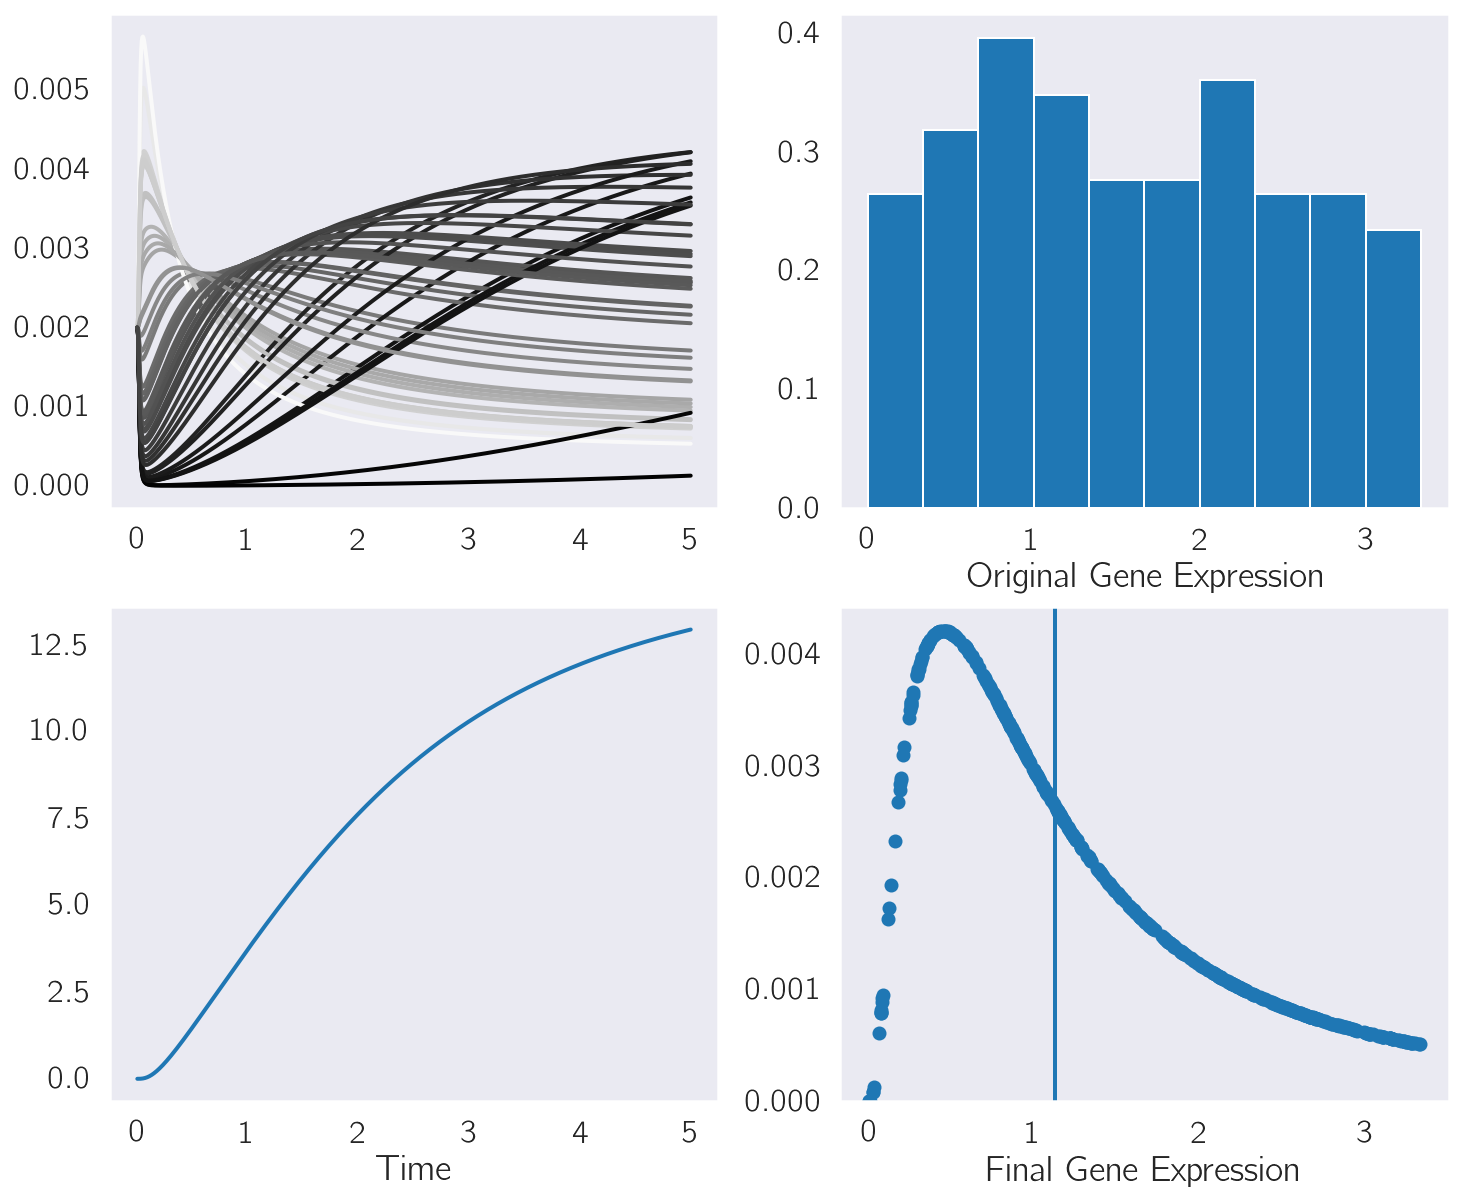

In [291]:
t = np.linspace(0, 5, 1000)
# params=y, B, K, N,
#        ap, yp, Kp, Np,
#        an, yn, Kn, Nn,
#        Kgn, Ngn
params = [3, 40 / len(ad), 1, 2,
          '10', 1.5, 500, 2,
          0, 1, 1, 1,
          1, 1]
ad, sims = simulation(params, Ncells=500, t=t, adlim=[0, 10])
plot_sims(ad, sims, t)

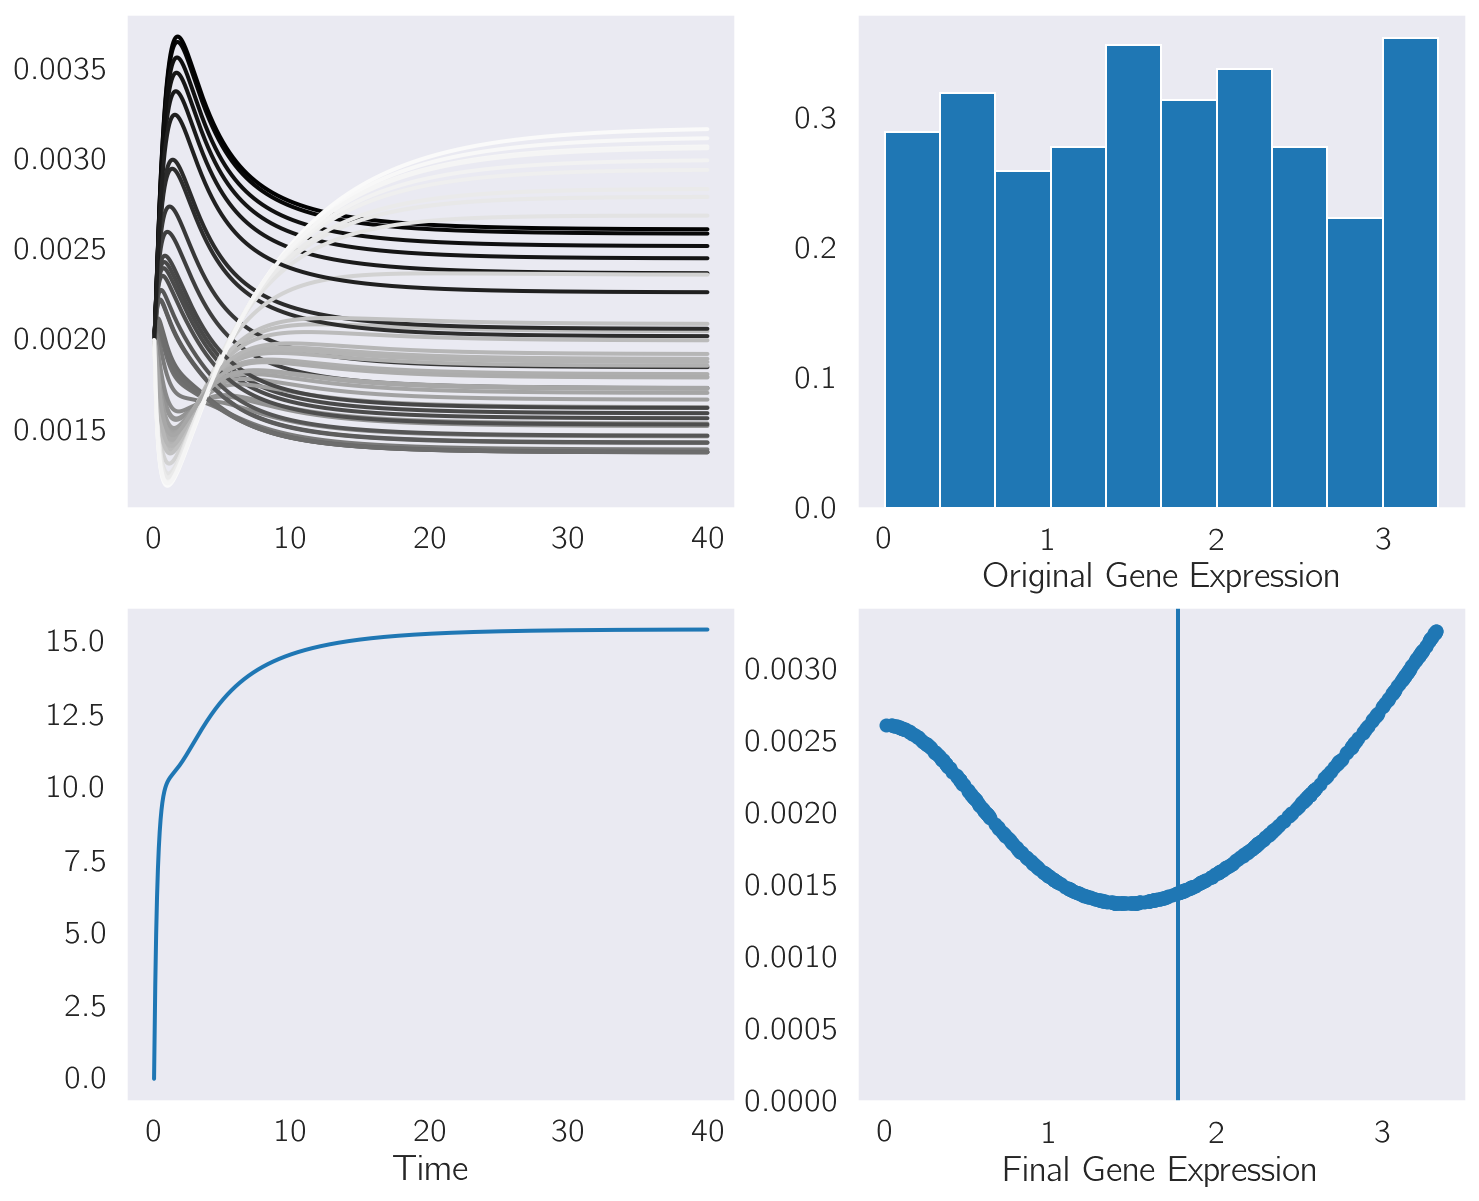

In [295]:
t = np.linspace(0, 40, 5000)
# params=y, B, K, N,
#        ap, yp, Kp, Np,
#        an, yn, Kn, Nn,
#        Kgn, Ngn
params = [3, 40 / len(ad), 1, 2,
          0, 1.5, 500, 2,
          3, 1, 1., 2,
          .5, 2]
ad, sims = simulation(params, Ncells=500, t=t, adlim=[0, 10])
plot_sims(ad, sims, t)

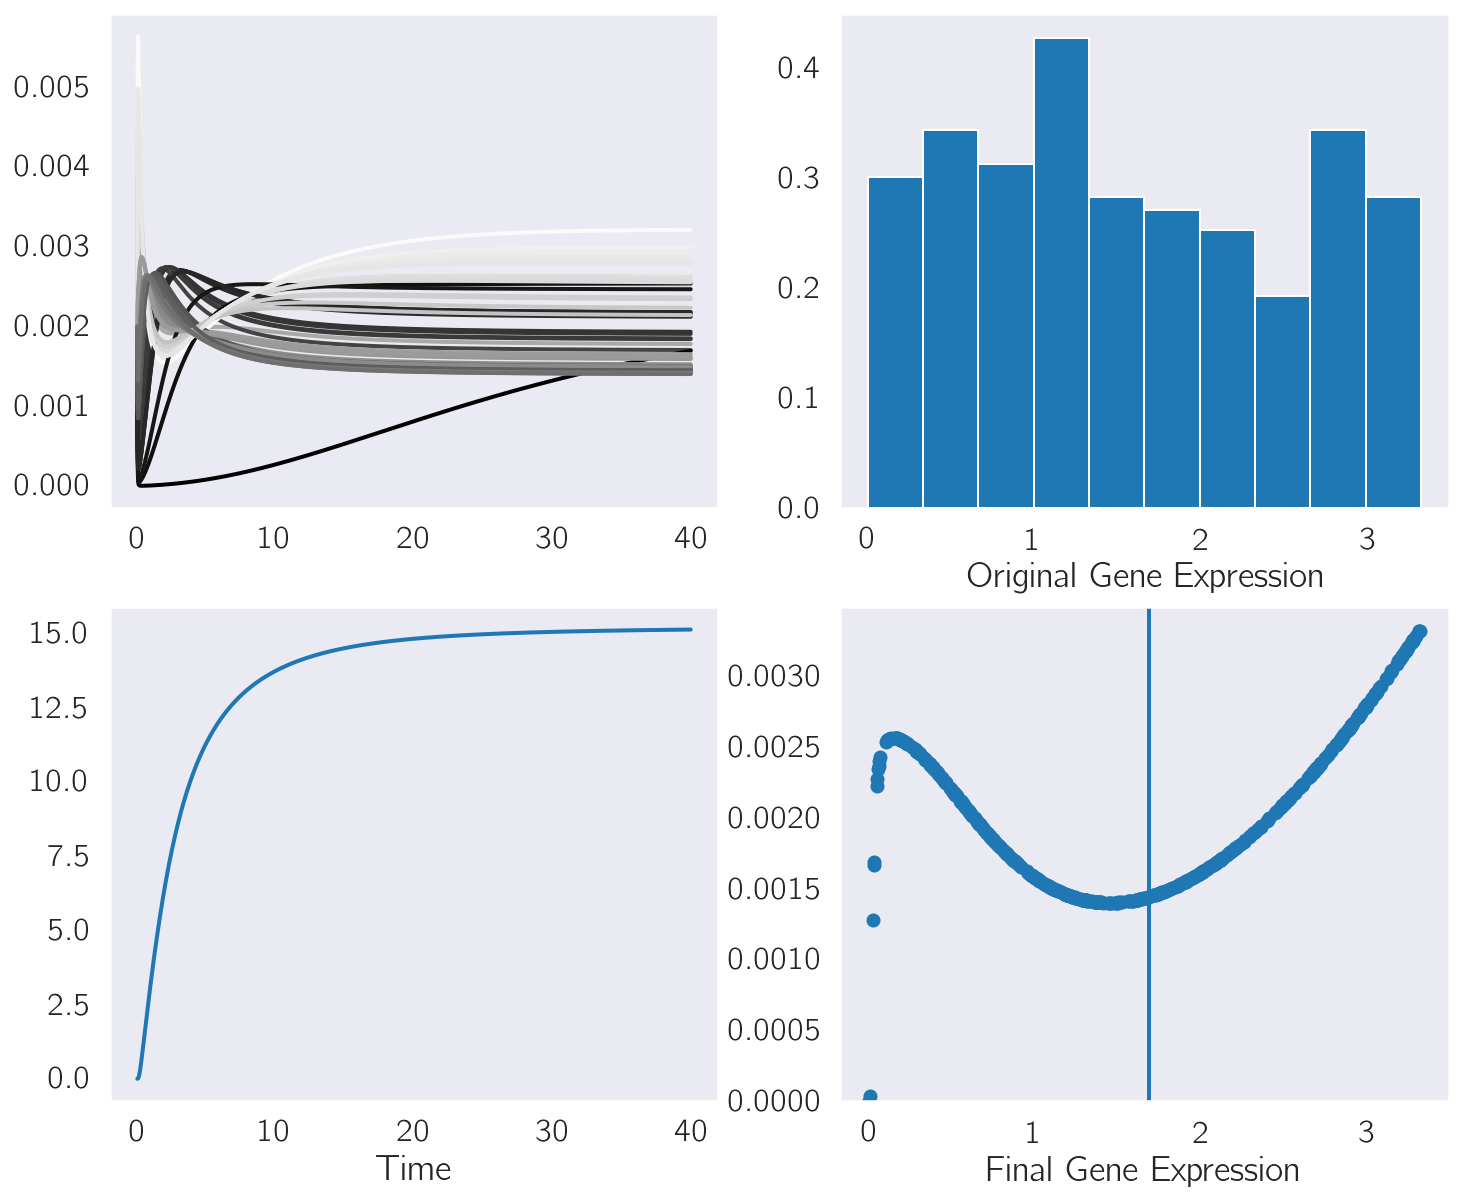

In [296]:
t = np.linspace(0, 40, 5000)
# params=y, B, K, N,
#        ap, yp, Kp, Np,
#        an, yn, Kn, Nn,
#        Kgn, Ngn
params = [3, 40 / len(ad), 1, 2,
          '10', 1.5, 500, 2,
          3, 1, 1., 2,
          .5, 2]
ad, sims = simulation(params, Ncells=500, t=t, adlim=[0, 10])
plot_sims(ad, sims, t)